<a href="https://colab.research.google.com/github/Deep-of-Machine/AI_Academy/blob/main/9_2_Mario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 슈퍼 마리오 브라더스 

In [1]:
!pip install gym-super-mario-bros==7.3.0

     |████████████████████████████████| 198 kB 5.0 MB/s 
     |████████████████████████████████| 76 kB 2.7 MB/s 
  Created wheel for nes-py: filename=nes_py-8.1.8-cp37-cp37m-linux_x86_64.whl size=438939 sha256=76501ee2a9f12ed818c889341697d07a7092242cfa780774e1007e61da1e9caa
  Stored in directory: /root/.cache/pip/wheels/f2/05/1f/608f15ab43187096eb5f3087506419c2d9772e97000f3ba025
Successfully built nes-py


In [2]:
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os, copy, time
from matplotlib import pyplot as plt
from IPython.display import clear_output

# Gym is an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Super Mario environment for OpenAI Gym
import gym_super_mario_bros

## 환경 불러오기




In [3]:
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
print(env.observation_space)
print(env.action_space)

Box(0, 255, (240, 256, 3), uint8)
Discrete(256)


In [4]:
state = env.reset()
print(type(state))

<class 'numpy.ndarray'>


In [5]:
print(state.shape)

(240, 256, 3)


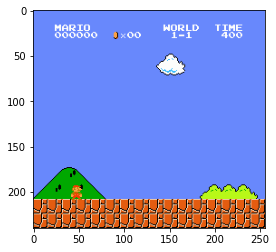

In [6]:
plt.imshow(state)
plt.show()

In [7]:
one_step = env.step(10)
print(type(one_step))

<class 'tuple'>


In [8]:
len(one_step)

4

In [10]:
print(one_step[0].shape)
print(one_step[1])
print(one_step[2])
print(one_step[3])

(240, 256, 3)
0
False
{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 79}


## 액션 간소화

In [11]:
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")

In [12]:
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [14]:
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env.reset()
next_state, reward, done, info = env.step(action=0)
print(env.action_space)
print(next_state.shape)
print(reward)
print(done)
print(info)

Discrete(7)
(240, 256, 3)
0
False
{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 79}


7개의 액션을 무작위로 선택한다면?

In [24]:
0.1*0.95**200

3.5052666248828703e-06

더 간단하게 2개의 액션을 사용한다면?

In [25]:
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
SIMPLE_MOVEMENT = [['right'], ['right', 'A']]


## 환경 전처리    
SkipFrame : 중간의 프레임 스킵    
GrayScaleObservation : 컬러 이미지를 흑백으로 변환    
ResizeObservation : 240 x 256 크기의 이미지를 84 x 84 크기로 변환    
FrameStack : 이전 프레임까지 포함해서 총 4장의 이미지를 반환

In [26]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

In [27]:
state = env.reset()
print(state.shape)

(4, 84, 84)


## 학습할 에이전트 클래스


In [ ]:
class Mario:
    def __init__():
        pass

    def act(self, state):
        """Given a state, choose an epsilon-greedy action"""
        pass

    def cache(self, experience):
        """Add the experience to memory"""
        pass

    def recall(self):
        """Sample experiences from memory"""
        pass

    def learn(self):
        """Update online action value (Q) function with a batch of experiences"""
        pass

## Act
상태가 주어졌을 때, 입실론 그리디 방법으로 취할 액션을 선택    
입실론의 값을 조금씩 바꿔서 점점 이용을 증가


In [57]:
class Mario:
    def __init__(self, state_dim, action_dim, save_dir):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

        self.use_cuda = torch.cuda.is_available()

        # Mario's DNN to predict the most optimal action - we implement this in the Learn section
        self.net = MarioNet(self.state_dim, self.action_dim).float()
        if self.use_cuda:
            self.net = self.net.to(device="cuda")

        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        self.save_every = 5e5  # no. of experiences between saving Mario Net

    def act(self, state):
        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # EXPLOIT
        else:
            state = state.__array__()
            if self.use_cuda:
                state = torch.tensor(state).cuda()
            else:
                state = torch.tensor(state)
            state = state.unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis = 1).item()
        # decrease exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)
        
        # increment step
        self.curr_step += 1
        return action_idx

## Cache and Recall
액션을 취해서 상태가 변하고 보상을 받으면, 그 결과를 저장    
저장된 경험에서 한 번의 학습에 사용 할 배치를 가져오기



In [58]:
class Mario(Mario):  # subclassing for continuity
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.memory = deque(maxlen=30000)
        self.batch_size = 32

    def cache(self, state, next_state, action, reward, done):
        
        state = state.__array__()
        next_state = next_state.__array__()

        if self.use_cuda:
            state = torch.tensor(state).cuda()
            next_state = torch.tensor(next_state).cuda()
            action = torch.tensor([action]).cuda()
            reward = torch.tensor([reward]).cuda()
            done = torch.tensor([done]).cuda()
        else:
            state = torch.tensor(state)
            next_state = torch.tensor(next_state)
            action = torch.tensor([action])
            reward = torch.tensor([reward])
            done = torch.tensor([done])

        self.memory.append((state, next_state, action, reward, done,))

    def recall(self):

        batch = random.sample(self.memory, self.batch_size)
        state, next_state, action, reward, done = map(torch.stack, zip(*batch))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

## 학습에 사용할 모델(DDQN) 정의



In [59]:
class MarioNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

        self.target = copy.deepcopy(self.online)

        # Q_target parameters are frozen.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

In [60]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.gamma = 0.9

    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

## 위에서 정의한 모델 학습


In [61]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()

    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()


    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())

## 학습한 모델 저장

In [62]:
class Mario(Mario):
    def save(self):
        save_path = (self.save_dir / f"mario_net_{int(self.curr_step // self.save_every)}.pth")
        torch.save(self.net.state_dict(), save_path)
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")

## Learn


In [63]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.burnin = 1e4  # min. experiences before training
        self.learn_every = 3  # no. of experiences between updates to Q_online
        self.sync_every = 1e4  # no. of experiences between Q_target & Q_online sync

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # Sample from memory
        state, next_state, action, reward, done = self.recall()

        # Get TD Estimate
        td_est = self.td_estimate(state, action)
        # Get TD Target
        td_tgt = self.td_target(reward, next_state, done)

        # Backpropagate loss through Q_online
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)

## Logging
학습 결과를 시각화하고 저장

In [64]:
class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_rewards", "ep_lengths", "ep_avg_losses", "ep_avg_qs"]:
            plt.plot(getattr(self, f"moving_avg_{metric}"))
            plt.savefig(getattr(self, f"{metric}_plot"))
            plt.clf()

# 학습 시작




In [65]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")

Using CUDA: True


In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
save_dir = Path('/content/drive/MyDrive/SuperMario_DDQN') / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)
logger = MetricLogger(save_dir)

mario = Mario(state_dim=(4,84,84), action_dim=env.action_space.n, save_dir=save_dir)

episodes = 1000000
for e in range(1, episodes + 1):

    state=env.reset()

    while True:
        action = mario.act(state)
        next_state, reward, done, info = env.step(action)
        mario.cache(state, next_state, action, reward, done)
        q, loss = mario.learn()
        logger.log_step(reward, loss, q)
        state = next_state
        if done or info["flag_get"]:
            break

    logger.log_episode()

    if e % 20 ==0:
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)
        mario.save()


/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 20 - Step 39160 - Epsilon 0.9902577648331903 - Mean Reward 515.05 - Mean Length 1958.0 - Mean Loss 0.511 - Mean Q Value 0.258 - Time Delta 511.836 - Time 2021-10-30T07:32:24
MarioNet saved to /content/drive/MyDrive/SuperMario_DDQN/2021-10-30T07-23-52/mario_net_0.pth at step 39160


KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

## 학습된 에이전트 확인

In [ ]:
luisi = Mario(state_dim=(4,84,84),action_dim=env.action_space.n, save_dir=save_dir)

In [ ]:
luisi.net.online

In [ ]:
luisi.net.load_state_dict(torch.load('드라이브 위치'))

In [ ]:
max_step = 5000
init_step = 0
done = False

state = env.reset()
while not done:
    clear_output(wait=True)
    action = luisi.act(state)
    next_state, reward, done, info = env.step(action)
    state =  next_state
    plt.imshow(next_state[3], cmap='gray')
    plt.show()
    init_step +=1
    print('\n {}th action {}, x_pos: {}'.format(init_step, action, info['x_pos']))

    if info["flag_get"]:
        print("Get Flag!")
        break

    if done:
        print('Fail')
        break

## 저장된 모델 불러오기